In [1]:
#x01_populationStatistics

In [2]:
# from chewc.chewc import *
# import torch
import torch.nn as nn
import torch.nn.functional as F
# import matplotlib.pyplot as plt

In [11]:
import torch
import matplotlib.pyplot as plt
from fastcore.basics import patch
import uuid
import pdb
import torch
from matplotlib.animation import FuncAnimation

device='cpu'

class Genome:
    def __init__(self, n_chr, n_loci):
        self.ploidy = 2
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.shape = (self.ploidy, self.n_chr, self.n_loci)
        
class Population:
    def __init__(self, genome, haplotypes, device=device):
        self.genome = genome
        self.device = device
        self.phenotypes = None
        self.bvs = None
        self.haplotypes = haplotypes
        self.dosages = haplotypes.sum(dim=1).float()
        self.size = haplotypes.shape[0]
                
class Trait:
    def __init__(self, genome, founder_population, target_mean, target_variance, device=device):
        self.target_mean = target_mean
        self.target_variance = target_variance
        self.device = device
        random_effects = torch.randn(genome.n_chr, genome.n_loci, device=self.device)
        random_effects -= random_effects.mean()
        founder_scores = torch.einsum('kl,hkl->h', random_effects, founder_population.dosages)
        founder_mean, founder_var = founder_scores.mean(), founder_scores.var()
        scaling_factors = torch.sqrt(self.target_variance / founder_var)
        self.scaling_factors = scaling_factors
        random_effects *= scaling_factors
        self.effects = random_effects
        self.intercept = founder_mean - target_mean

        
def calculate_breeding_value(population_dosages, trait_effects, device = device):
    return torch.einsum('hjk,jk->h', population_dosages,trait_effects)

def truncation_selection(population, trait, top_percent):
    return torch.topk(population.phenotypes, top_percent).indices

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape    
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:],parent_haplo_tensor[:,1,:,:],
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
    #crossovers = torch.rand((num_individuals, num_chromosomes, num_loci), device=device) < recombination_rate
    progeny = maternal * (1 - crossovers) + paternal * crossovers
    return progeny


def phenotype(population, trait, h2):
    breeding_values = calculate_breeding_value(population.dosages, trait.effects) 
    
    if breeding_values.var() == 0:
#         print('phenotype: no var')
        environmental_variance = 0  
    else:
        environmental_variance = (1 - h2) / h2 * breeding_values.var() 
    
    # Check if environmental_variance is zero before applying torch.sqrt and .clone()
    if environmental_variance == 0:
        environmental_noise = torch.zeros(breeding_values.shape, device=device)
    else:
        environmental_noise = torch.randn(breeding_values.shape, device=device) * torch.sqrt(environmental_variance).detach()
    
    population.breeding_values = breeding_values
    population.phenotypes = breeding_values + environmental_noise
#     def _create_random_haplotypes(self,num_individuals):
#         return torch.randint(0, 2, (num_individuals, *self.g.shape), device=self.device)
def create_random_pop(G, pop_size):
    return torch.randint(0, 2, (pop_size, *G.shape), device= device)

def update_pop(population, haplotype_pop_tensor):
    population.haplotypes = haplotype_pop_tensor
    population.dosages = haplotype_pop_tensor.sum(dim=1).float()
    return population

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:],parent_haplo_tensor[:,1,:,:],
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
#     crossovers = torch.rand((num_individuals, num_chromosomes, num_loci), device=device) < recombination_rate
    progeny = maternal * torch.logical_not(crossovers) + paternal * crossovers
    return progeny

def breed(mother_tensor, father_tensor, recombination_rate=0.1):
    eggs = recombine(mother_tensor,recombination_rate)
    pollens = recombine(father_tensor,recombination_rate)
    return torch.stack((eggs,pollens), dim=1)

def create_pop(G, haplotypes):
    return Population(G, haplotypes=haplotypes)

def bv(P,T):
    P.breeding_values = calculate_breeding_value(P.dosages,T.effects)
    
def create_progeny(mother_gametes, father_gametes,reps = 1):
    progeny = []
    for _ in range(reps):
        # Randomly shuffle the gametes from each parent 
        shuffled_mother_indices = torch.randperm(mother_gametes.shape[0])
        shuffled_father_indices = torch.randperm(father_gametes.shape[0])

        # Select the shuffled gametes
        mother_gametes = mother_gametes[shuffled_mother_indices]
        father_gametes = father_gametes[shuffled_father_indices]

        # Stack the gametes to create progeny haplotypes
        progeny_haplotypes = torch.stack((mother_gametes, father_gametes),dim=1)
        progeny.append(progeny_haplotypes)
    return torch.vstack(progeny)


class MyNetwork(nn.Module):
    def __init__(self, L, P):
        super(MyNetwork, self).__init__()
        
        # Layers for input1 and input3
        self.fc1 = nn.Linear(L, 128)
        self.fc2 = nn.Linear(128, 64)
        
        # Layers for input2
        self.fc3 = nn.Linear(P, 128)
        self.fc4 = nn.Linear(128, 64)
        
        # Layers for the upper triangle of input_matrix
        self.fc_matrix = nn.Linear(L * (L + 1) // 2, 256)
        
        # Final fully connected layers
        self.fc_final1 = nn.Linear(64 * 3 + 256, 64)
        self.fc_final2 = nn.Linear(64, 5)  # Changed from 10 to 5 for a single choice with 5 values
    
    def forward(self, input1, input2, input3, input_matrix):
        
        # Process input1 and input3
        x1 = F.relu(self.fc1(input1))
        x1 = F.relu(self.fc2(x1))
        
        x3 = F.relu(self.fc1(input3))
        x3 = F.relu(self.fc2(x3))
        
        # Process input2
        x2 = F.relu(self.fc3(input2))
        x2 = F.relu(self.fc4(x2))
        
        # Process input_matrix
        indices = torch.triu_indices(input_matrix.size(1), input_matrix.size(2))
        upper_triangle = input_matrix[:, indices[0], indices[1]]
        x_matrix = F.relu(self.fc_matrix(upper_triangle))
        
        # Concatenate all features
        x = torch.cat((x1, x2, x3, x_matrix), dim=1)
        
        # Final fully connected layers
        x = F.relu(self.fc_final1(x))
        output = self.fc_final2(x)
        
        # Apply softmax to get probabilities for the single choice with 5 values
        output = F.softmax(output, dim=1)
        
        return output
    
    
def population_statistics(population_tensor):

    
    #Calculate the mean genotype value divided by 2 for each marker.
    def calculate_allele_frequencies(genotypes):
        num_individuals = genotypes.size(0)
        allele_frequencies = torch.mean(genotypes, dim=0) / 2.
        return allele_frequencies
    #Calculate the unique genotype counts and their frequencies.
    def calculate_genotype_frequencies(genotypes):
        num_individuals = genotypes.size(0)
        unique_genotypes, counts = torch.unique(genotypes, dim=0, return_counts=True)
        genotype_frequencies = counts.float() / num_individuals
        return unique_genotypes, genotype_frequencies
    #Calculate the proportion of heterozygous individuals at each marker.
    def calculate_heterozygosity(genotypes):
        num_individuals = genotypes.size(0)
        heterozygosity = torch.sum(genotypes == 1, dim=0).float() / num_individuals
        return heterozygosity
    #Calculate the frequency of the less common allele.
    def calculate_maf(genotypes):
        allele_frequencies = calculate_allele_frequencies(genotypes)
        maf = torch.minimum(allele_frequencies, 1 - allele_frequencies)
        return maf
    #Measure the degree of inbreeding based on observed and expected heterozygosity.
    def calculate_inbreeding_coefficient(genotypes):
        num_markers = genotypes.size(1)
        observed_heterozygosity = torch.sum(genotypes == 1, dim=1).float() / num_markers
        expected_heterozygosity = 2 * calculate_allele_frequencies(genotypes) * (1 - calculate_allele_frequencies(genotypes))
        average_expected_heterozygosity = torch.mean(expected_heterozygosity)
        inbreeding_coefficient = 1 - (observed_heterozygosity / average_expected_heterozygosity)
        return inbreeding_coefficient
    #Calculate the correlation matrix for the genotypes.
    def calculate_ld(genotypes):
        num_markers = genotypes.size(1)
        ld_matrix = torch.corrcoef(genotypes.T)
        return ld_matrix
    #Measure the genetic differentiation between subpopulations.
    def calculate_fst(genotypes, subpopulations):
        total_allele_frequencies = calculate_allele_frequencies(genotypes)
        subpop_allele_frequencies = [calculate_allele_frequencies(genotypes[subpop]) for subpop in subpopulations]
        ht = 2 * total_allele_frequencies * (1 - total_allele_frequencies)
        hs = torch.mean(torch.stack([2 * freq * (1 - freq) for freq in subpop_allele_frequencies]), dim=0)
        fst = (ht - hs) / ht
        return fst
    #Estimate the effective population size based on allele frequencies and genetic drift.
    def calculate_effective_population_size(genotypes):
        num_individuals = genotypes.size(0)
        allele_frequencies = calculate_allele_frequencies(genotypes)
        variance = torch.var(allele_frequencies)
        ne = (num_individuals - 1) / (2 * variance)
        return ne

    genotypes = population_tensor
    stats = {
        'allele_frequencies': calculate_allele_frequencies(genotypes),
        'genotype_frequencies': calculate_genotype_frequencies(genotypes),
        'heterozygosity': calculate_heterozygosity(genotypes),
        'maf': calculate_maf(genotypes),
        'inbreeding_coefficient': calculate_inbreeding_coefficient(genotypes),
        'ld_matrix': calculate_ld(genotypes),
        'effective_population_size': calculate_effective_population_size(genotypes)
    }
    return stats

class BreedingSimulation:
    def __init__(self, G, T, h2, reps, pop_size, max_generations=10, variance_threshold=1e-6):
        self.G = G
        self.T = T
        self.h2 = h2
        self.reps = reps
        self.pop_size = pop_size
        self.max_generations = max_generations
        self.variance_threshold = variance_threshold

        # Create and store the initial population
        self.initial_haplotypes = create_random_pop(G, pop_size)
        self.initial_population = create_pop(G, self.initial_haplotypes)
        phenotype(self.initial_population, self.T, self.h2)
        
        # Initialize current population
        self.population = self.initial_population
        self.history = []
        self.current_generation = 0
        
    def step(self, actions):
        # Log current population
        current_state = self.get_state()
        self.track_data(actions, self.calculate_reward())

        # Select parents based on actions
        selected_parent_indices = self.select_parents(actions)
        selected = self.population.haplotypes[selected_parent_indices]

        # Breeding
        m = recombine(selected)  # Mother gametes
        f = recombine(selected)  # Father gametes
        progeny = create_progeny(m, f, reps=action2[actions])  # Create progeny

        # Create new population from progeny
        new_pop = create_pop(self.G, progeny)
        phenotype(new_pop, self.T, self.h2)

        # Switch current population to progeny population
        self.population = new_pop
        # Check if episode is done
        done = self.is_done()
        # Calculate reward only if the episode is done
#         reward = self.calculate_reward() if self.is_done() else 0
        reward = self.calculate_reward()
#         print(self.population.phenotypes.var())
        # Get new state
        new_state = self.get_state()

        # Increment generation counter
        self.current_generation += 1



        return new_state, reward, done

    def select_parents(self, actions):
        if self.population.phenotypes is None:
            phenotype(self.population, self.T, self.h2)
        parents = torch.topk(self.population.phenotypes, int(action1[actions])).indices
        
        return parents
    

    def calculate_reward(self):
        initial_phenotype = self.initial_population.phenotypes.mean()
        current_phenotype = self.population.phenotypes.mean()
        return current_phenotype - initial_phenotype
    def is_done(self):
#         # Check if max generations reached or phenotypic variance is too low
#         if self.current_generation >= self.max_generations:
#             return True
#         if self.population.phenotypes.var() < self.variance_threshold:
#             return True
#         return False
        return self.current_generation >= self.max_generations


    def reset(self):
        # Reset to the initial population
        self.population = create_pop(self.G, self.initial_haplotypes.clone())
        phenotype(self.population, self.T, self.h2)
        self.history = []
        self.current_generation = 0
        return self.get_state()
    
    def get_state(self):
        # Calculate population statistics here
        n_ind, n_chr, n_loci = self.population.haplotypes.sum(dim=1).shape
        pop_stat_in  = self.population.haplotypes.sum(dim=1).view((n_ind, n_chr* n_loci))
        pop_stat = population_statistics(pop_stat_in.float())

        # Create a dictionary to hold state features
        state = {
            'avg_phenotype': self.population.phenotypes.mean(),
            'phenotype_variance': self.population.phenotypes.var(),
            'avg_breeding_value': self.population.breeding_values.mean(),
            'heterozygosity': pop_stat['heterozygosity'],
#             'allele_frequencies': pop_stat['allele_frequencies'],
            'maf': pop_stat['maf'], # Assuming your model uses the whole maf vector
            'inbreeding_coefficient': pop_stat['inbreeding_coefficient'],
            'ld_matrix': pop_stat['ld_matrix'],
            'genotype_frequencies': pop_stat['genotype_frequencies'][1]
            # Add any other relevant features from pop_stat
        }
        return state

    def track_data(self, actions, reward):
        # Reuse state features from get_state()
        state = self.get_state()
        gen_data = {
            'generation': len(self.history),
            'avg_phenotype': state['avg_phenotype'].item(),
            'phenotype_variance': state['phenotype_variance'].item(),
            'avg_breeding_value': state['avg_breeding_value'].item(),
            'actions': actions,
            'reward': reward,
            'n_ind': self.pop_size,  # Assuming 'n_ind' is calculated in get_state()
            'heterozygosity': state['heterozygosity'].mean(),
#             'allele_frequencies': state['allele_frequencies'].mean(),
            'maf': state['maf'].mean().mean(),
            'inbreeding_coefficient': state['inbreeding_coefficient'].mean().item(),
            # ... include other items from pop_stat as needed ...
        }
        self.history.append(gen_data)

    def plot_history(self):
        def normalize(data):
            min_val = min(data)
            max_val = max(data)
            return [(x - min_val) / (max_val - min_val) for x in data]
        generations = [d['generation'] for d in self.history]
        avg_phenotypes = [d['avg_phenotype'] for d in self.history]
        actions = [d['maf'] for d in self.history]
        
        avg_phenotypes = normalize(avg_phenotypes)
        actions = normalize(actions)
        plt.plot(generations, avg_phenotypes)
        plt.plot(generations, actions)
        plt.xlabel('Generation')
        plt.ylabel('Average Phenotype')
        plt.title('Breeding Progress')
        plt.show()
        
n_chr = 1
n_loci = 100
founder_pop_size = 200

G = Genome(n_chr, n_loci)
founder_pop = create_pop(G, create_random_pop(G, founder_pop_size))
T = Trait(G, founder_pop, target_mean=0.0, target_variance=1.0)

sim = BreedingSimulation(G, T, h2=.99, reps=1, pop_size=founder_pop_size,max_generations=5000)

model = MyNetwork(n_loci*n_chr, founder_pop_size)


In [12]:
sim.population.haplotypes.shape

torch.Size([200, 2, 1, 100])

Episode 2 finished with reward: 448.6737976074219, generations: 101
Episode 4 finished with reward: 677.7727661132812, generations: 101
Episode 6 finished with reward: 427.2093811035156, generations: 101
Episode 8 finished with reward: 609.129638671875, generations: 101
Episode 10 finished with reward: 651.2470703125, generations: 101
Episode 12 finished with reward: 485.5218200683594, generations: 101
Episode 14 finished with reward: 688.2605590820312, generations: 101
Episode 16 finished with reward: 851.21923828125, generations: 101
Episode 18 finished with reward: 560.0086059570312, generations: 101
Episode 20 finished with reward: 626.4763793945312, generations: 101
Episode 22 finished with reward: 478.9024353027344, generations: 101
Episode 24 finished with reward: 484.3839111328125, generations: 101
Episode 26 finished with reward: 481.250732421875, generations: 101
Episode 28 finished with reward: 602.3632202148438, generations: 101
Episode 30 finished with reward: 678.03680419

Episode 240 finished with reward: 744.901123046875, generations: 101
Episode 242 finished with reward: 493.15997314453125, generations: 101
Episode 244 finished with reward: 442.1144714355469, generations: 101
Episode 246 finished with reward: 509.56561279296875, generations: 101
Episode 248 finished with reward: 554.0283813476562, generations: 101
Episode 250 finished with reward: 417.76629638671875, generations: 101
Episode 252 finished with reward: 593.5148315429688, generations: 101
Episode 254 finished with reward: 578.7499389648438, generations: 101
Episode 256 finished with reward: 613.6653442382812, generations: 101
Episode 258 finished with reward: 507.7250671386719, generations: 101
Episode 260 finished with reward: 531.6969604492188, generations: 101
Episode 262 finished with reward: 685.799072265625, generations: 101
Episode 264 finished with reward: 544.61279296875, generations: 101
Episode 266 finished with reward: 702.9415893554688, generations: 101
Episode 268 finished 

Episode 476 finished with reward: 512.9281005859375, generations: 101
Episode 478 finished with reward: 457.65264892578125, generations: 101
Episode 480 finished with reward: 608.7532958984375, generations: 101
Episode 482 finished with reward: 478.8534240722656, generations: 101
Episode 484 finished with reward: 675.3920288085938, generations: 101
Episode 486 finished with reward: 570.8034057617188, generations: 101
Episode 488 finished with reward: 279.0040588378906, generations: 101
Episode 490 finished with reward: 508.5534973144531, generations: 101
Episode 492 finished with reward: 699.3375854492188, generations: 101
Episode 494 finished with reward: 570.7462768554688, generations: 101
Episode 496 finished with reward: 654.9948120117188, generations: 101
Episode 498 finished with reward: 335.7502746582031, generations: 101
Episode 500 finished with reward: 483.546630859375, generations: 101
Episode 502 finished with reward: 586.1380004882812, generations: 101
Episode 504 finished

Episode 712 finished with reward: 630.830078125, generations: 101
Episode 714 finished with reward: 486.8788757324219, generations: 101
Episode 716 finished with reward: 559.7998657226562, generations: 101
Episode 718 finished with reward: 443.5202331542969, generations: 101
Episode 720 finished with reward: 802.083251953125, generations: 101
Episode 722 finished with reward: 505.240966796875, generations: 101
Episode 724 finished with reward: 723.1799926757812, generations: 101
Episode 726 finished with reward: 456.6328430175781, generations: 101
Episode 728 finished with reward: 640.0465087890625, generations: 101
Episode 730 finished with reward: 671.6904296875, generations: 101
Episode 732 finished with reward: 648.7913818359375, generations: 101
Episode 734 finished with reward: 767.9974975585938, generations: 101
Episode 736 finished with reward: 371.2184143066406, generations: 101
Episode 738 finished with reward: 446.4309387207031, generations: 101
Episode 740 finished with rew

Episode 948 finished with reward: 498.2311706542969, generations: 101
Episode 950 finished with reward: 760.6002197265625, generations: 101
Episode 952 finished with reward: 370.5852355957031, generations: 101
Episode 954 finished with reward: 631.2410888671875, generations: 101
Episode 956 finished with reward: 596.3095703125, generations: 101
Episode 958 finished with reward: 466.6166687011719, generations: 101
Episode 960 finished with reward: 671.3895874023438, generations: 101
Episode 962 finished with reward: 709.1343994140625, generations: 101
Episode 964 finished with reward: 431.1832580566406, generations: 101
Episode 966 finished with reward: 444.7201232910156, generations: 101
Episode 968 finished with reward: 594.865966796875, generations: 101
Episode 970 finished with reward: 640.7417602539062, generations: 101
Episode 972 finished with reward: 471.3105773925781, generations: 101
Episode 974 finished with reward: 413.7425842285156, generations: 101
Episode 976 finished wit

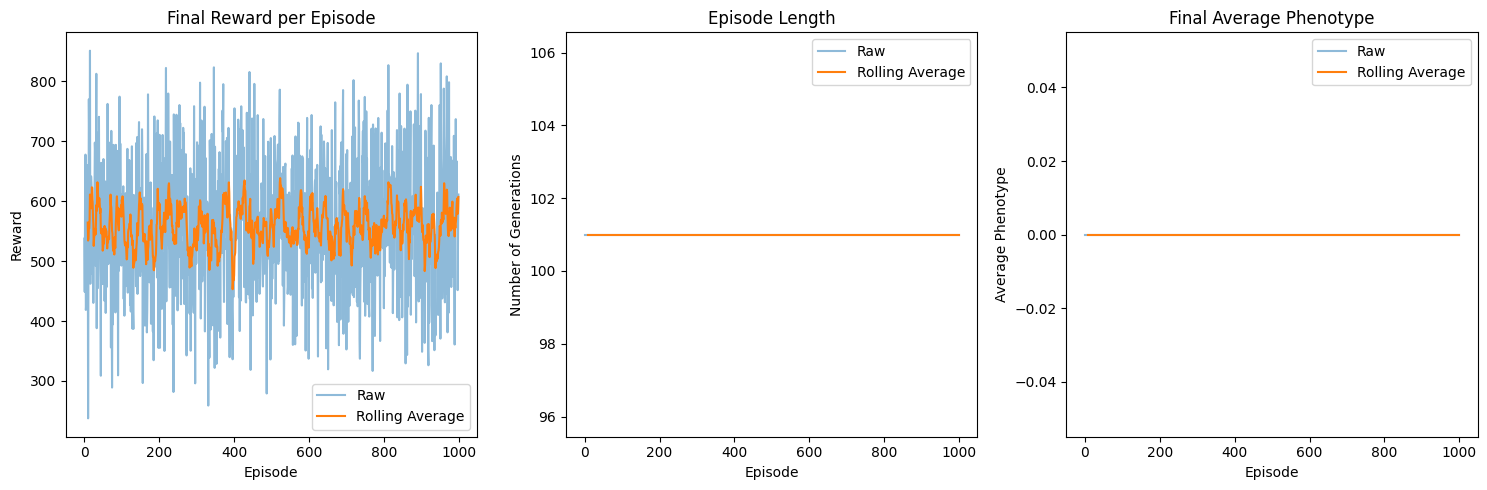

In [13]:
class EpisodeData:
    def __init__(self):
        self.final_reward = 0
        self.episode_length = 0
        self.final_avg_phenotype = 0
        self.final_phenotype_variance = 0
        self.final_avg_breeding_value = 0
        self.final_heterozygosity = 0
        self.final_maf = 0
        self.final_inbreeding_coefficient = 0
        self.actions_taken = []

class MetaAnalysis:
    def __init__(self):
        self.episodes = []

    def add_episode(self, episode_data):
        self.episodes.append(episode_data)

    def get_summary(self):
        # Implement summary statistics here
        pass    #initialize the settings
    
def analyze_learning_progress(meta_analysis, window_size=10):
    episode_rewards = [ep.final_reward for ep in meta_analysis.episodes]
    episode_lengths = [ep.episode_length for ep in meta_analysis.episodes]
    final_phenotypes = [ep.final_avg_phenotype for ep in meta_analysis.episodes]
    
    def rolling_average(data, window_size):
        cumsum = np.cumsum(np.insert(data, 0, 0)) 
        return (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    
    rolling_rewards = rolling_average(episode_rewards, window_size)
    rolling_lengths = rolling_average(episode_lengths, window_size)
    rolling_phenotypes = rolling_average(final_phenotypes, window_size)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(episode_rewards, alpha=0.5, label='Raw')
    plt.plot(range(window_size-1, len(episode_rewards)), rolling_rewards, label='Rolling Average')
    plt.title('Final Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(episode_lengths, alpha=0.5, label='Raw')
    plt.plot(range(window_size-1, len(episode_lengths)), rolling_lengths, label='Rolling Average')
    plt.title('Episode Length')
    plt.xlabel('Episode')
    plt.ylabel('Number of Generations')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(final_phenotypes, alpha=0.5, label='Raw')
    plt.plot(range(window_size-1, len(final_phenotypes)), rolling_phenotypes, label='Rolling Average')
    plt.title('Final Average Phenotype')
    plt.xlabel('Episode')
    plt.ylabel('Average Phenotype')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    
import torch
import torch.optim as optim
import torch.nn.functional as F

# Add these to your RLAgent class
class RLAgent:
    def __init__(self, model):
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.05)
        self.log_probs = []
        self.rewards = []

    def select_action(self, state):
        try:
            input1 = state['maf'].unsqueeze(0)
            input2 = state['inbreeding_coefficient'].unsqueeze(0) 
            input3 = state['heterozygosity'].unsqueeze(0)

            # Replace NaN values with 0 in the LD matrix
            input_matrix = state['ld_matrix'].unsqueeze(0)
            input_matrix = torch.nan_to_num(input_matrix, nan=0.0)

            action_probs = self.model(input1, input2, input3, input_matrix)

            # Ensure action_probs are valid probabilities
            action_probs = torch.nan_to_num(action_probs, nan=1e-8)
            action_probs = F.softmax(action_probs, dim=-1)

            m = torch.distributions.Categorical(action_probs)
            action = m.sample()
            self.log_probs.append(m.log_prob(action))
            return action.item()

        except Exception as e:
            print("\n--- Error in select_action method ---")
            print(f"Exception: {str(e)}")

            print("\nDebugging Information:")
            print("Input1 (MAF) shape:", input1.shape if 'input1' in locals() else "Not created")
            print("Input1 (MAF) values:", input1 if 'input1' in locals() else "Not created")

            print("Input2 (Inbreeding Coefficient) shape:", input2.shape if 'input2' in locals() else "Not created")
            print("Input2 (Inbreeding Coefficient) value:", input2 if 'input2' in locals() else "Not created")

            print("Input3 (Heterozygosity) shape:", input3.shape if 'input3' in locals() else "Not created")
            print("Input3 (Heterozygosity) values:", input3 if 'input3' in locals() else "Not created")

            print("Input Matrix (LD Matrix) shape:", input_matrix.shape if 'input_matrix' in locals() else "Not created")
            if 'input_matrix' in locals():
                print("Input Matrix (LD Matrix) snippet:", input_matrix[0, :5, :5])  # Print first 5x5 submatrix

            if 'action_probs' in locals():
                print("Action probabilities:", action_probs)

            if 'm' in locals():
                print("Categorical distribution:", m)

            if 'action' in locals():
                print("Sampled action:", action.item())

            if hasattr(self, 'log_probs') and self.log_probs:
                print("Last log probability:", self.log_probs[-1].item())

            print("State keys:", state.keys())
            for key, value in state.items():
                if isinstance(value, torch.Tensor):
                    print(f"{key} shape: {value.shape}")

            print("Model architecture:", self.model)

            raise  # Re-raise the exception after printing debug info

    def update_policy(self):
        policy_loss = []
        returns = []
        G = 0
        for r in self.rewards[::-1]:
            G = r + 0.90 * G  # 0.90 is the discount factor
            returns.insert(0, G)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        for log_prob, R in zip(self.log_probs, returns):
            policy_loss.append(-log_prob * R)

        self.optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()

        # Add entropy term
        probs = torch.exp(torch.cat(self.log_probs))
        entropy = -(probs * torch.log(probs)).sum()
        entropy_weight = 0.01  # Adjust this value as needed

        loss = policy_loss - entropy_weight * entropy
        loss.backward()
        self.optimizer.step()

        self.log_probs = []
        self.rewards = []

        
n_chr = 1
n_loci = 100
founder_pop_size = 200

G = Genome(n_chr, n_loci)
founder_pop = create_pop(G, create_random_pop(G, founder_pop_size))
T = Trait(G, founder_pop, target_mean=0.0, target_variance=1.0)

sim = BreedingSimulation(G, T, h2=.99, reps=1, pop_size=founder_pop_size,max_generations=100)

model = MyNetwork(n_loci*n_chr, founder_pop_size)
agent  = RLAgent(model)
# Define the actions
action1 = [5, 10, 20, 50, 100] # top k
action2 = [40, 20, 10, 4, 2] # number xagent = RLAgent(model)

# Modified training loop
meta_analysis = MetaAnalysis()
num_episodes = 1000
for episode in range(num_episodes):
    state = sim.reset()
    episode_data = EpisodeData()
    episode_reward = 0
    done = False
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, done = sim.step(action)
        agent.rewards.append(reward)
        episode_reward += reward
        episode_data.actions_taken.append(action)
        state = next_state
    
    # Update policy
    agent.update_policy()
    
    # Capture final state information
    episode_data.final_reward = episode_reward
    episode_data.episode_length = sim.current_generation
    # ... (rest of the episode data capture)

    meta_analysis.add_episode(episode_data)
    if (episode + 1) % 2 == 0:
        print(f"Episode {episode + 1} finished with reward: {episode_data.final_reward}, generations: {sim.current_generation}")


#     print(f"Episode {episode + 1} finished with reward: {episode_reward}")

# After training, you can analyze the learning progress
analyze_learning_progress(meta_analysis)

In [6]:
import numpy as np

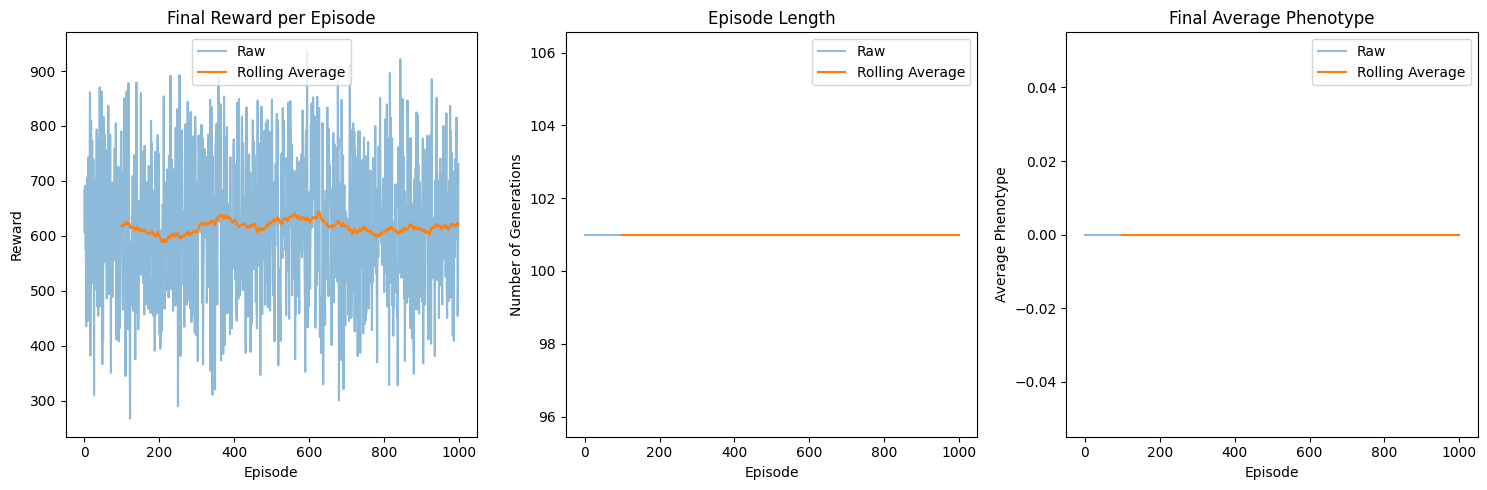

In [10]:

# After training, you can analyze the learning progress
analyze_learning_progress(meta_analysis, window_size=100)